Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

**REF:To Know more on the skip-gram models , the theoritical foundation please visit,
**

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import datetime

STEP 1 : Download Text data
----------------------------
Download the text data from the source website.

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)
print('Completed', datetime.datetime.now() )

Found and verified text8.zip
Completed 2017-05-29 18:14:03.804279


**Step 2 :Tokenize text data into words.**
---------------------

In [4]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data('text8_mid_30MB.zip')
print('Data size in number of words %d' % len(words))
print('Completed', datetime.datetime.now() )

Data size in number of words 5094672
Completed 2017-05-29 18:14:18.970274


In [5]:
print(type(words))
print(words[0:10])
print( " ".join(words[0:100]))

<type 'list'>
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing


Step 3: Build the  word  dictionary  i.e word - index 
------------------------------------------
1. Dictionary :  word - index dictionary as in  { word1 : 1, word2 : 2 }
2. Reverse_dictionary :  contains all words with key as index and value as word, so that it's easy to reference them e.g { word1 : 1, word2 : 2 } to reverse_dictionary becomes
{  1: word1 , 2: word2  }


In [6]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 97870], ('the', 325643), ('of', 182950), ('and', 127938), ('one', 116440)]
Sample data [3181, 2980, 12, 6, 181, 2, 3736, 49, 58, 149]


In [7]:
n_pairs_dict = {k : dictionary[k] for k in dictionary.keys()[:10]}
print('dictionary - ', n_pairs_dict )

n_pairs_reverse_dict = {k : reverse_dictionary[k] for k in reverse_dictionary.keys()[:10]}
print('reverse dictionary - ',n_pairs_reverse_dict)


dictionary -  {'fawn': 42300, 'homomorphism': 15286, 'nunnery': 29778, 'chthonic': 31253, 'sonja': 42301, 'woods': 6307, 'clotted': 42302, 'spiders': 13019, 'gai': 34017, 'hanging': 7083}
reverse dictionary -  {0: 'UNK', 1: 'the', 2: 'of', 3: 'and', 4: 'one', 5: 'in', 6: 'a', 7: 'to', 8: 'zero', 9: 'nine'}


Step 4:  Morph word frequency into Continous Bag of words data
------------------------------
CBOW model aims to predict the target word given n-context words. And in doing so, the nice side effect is that the word vectors are represented in an meaningful way capturing semantic and syntactic  relevance. 


**skip_window** = 1 # How many words to consider left and right for training. skip_window =1 means consider one word to the left one word to the right.

**num_skips** = 2 # How many times to reuse an input to generate a label.



In [8]:
print(type(data))
print(data[1:10])
print(reverse_dictionary[2307])
print(dictionary['originated']  )

key = [0,1]
a = {}
a[0] = 'a'
a[1] = 'b'
print(a[0],a)
for i in key:
    print(a[i])
print( [a[i] for i in key]) 

<type 'list'>
[2980, 12, 6, 181, 2, 3736, 49, 58, 149]
ohio
2980
a {0: 'a', 1: 'b'}
a
b
['a', 'b']


Question :: Is num_skips relevant for CBOW
---------------------------
**ANSWER:** Compared to earlier skip-gram model, num-step is irrelevant in  CBOW model, since CBOW model all the words collectively as random collection of bag of words. There is no individual (input, output pair) in CBOw model, hence num_skip[s is irrelevant for CBOw

In [9]:
batch =  [ [   31  ,  2], [   6 ,   31], [   31 ,3181] ]
labels = [[ 181],  [ 181], [2980] ]
#train_word_list = [ reverse_dictionary[bi[0][bi][0]  for bi in batch] 
print(reverse_dictionary[batch[0][0]] )
print( reverse_dictionary[31],  reverse_dictionary[2] )
#print( [ reverse_dictionary[bi[0]] + ','reverse_dictionary[bi[1]] for  bi in batch ] )

#print( [ reverse_dictionary[bi[0]] + ':' +reverse_dictionary[bi[1]] for  bi in batch ] )
print( [ [reverse_dictionary[bi[num]]  for num in range(len(batch[0]) )  ]  for  bi in batch ] )
#print([ reverse_dictionary[batch[0][bi]] for  bi in batch ] )
print(len(batch[0]))



his
his of
[['his', 'of'], ['a', 'his'], ['his', 'anarchism']]
2


In [10]:
data_index = 0

#CASE 1 :  batch_size = 8 and skip_window = 1
def generate_batch(batch_size, skip_window, reverse_dictionary = None , verbose = 0):
  global data_index  
  
  # batch_size, skip_window) => num of center_words  e.g (4,1)=>2 , (6,1)=>4, (8,1)=>6, (5,2)=>1, (7,2)=>3
  cbow_no_of_output_word = batch_size - (2 * skip_window)    

  # For Data : ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
  # and skip_window = 1, batch = ['anarchism',  'as' . Label = [ 'originated']
  # and skip_window = 2, batch = ['anarchism', 'originated', 'a', 'term', 'of'] . label = [ 'as']  
  batch = np.ndarray(shape=( cbow_no_of_output_word , 2 * skip_window ), dtype=np.int32)
  labels = np.ndarray(shape=( cbow_no_of_output_word ,1), dtype=np.int32)
  
  if verbose ==1:print('  batch size is  [',len(batch), len(batch[0]),'] label size is ::  [',  len(labels), len(labels[0]),']' )  
    
  # skip_window is the length of one side
  # span : length of the whole frame i.e skip_window no of words to the left and skip_window no of words to the right
  # CASE 1: span = 3
  span = 2 * skip_window + 1 # [ context_word1 target context_word2 ] [w-1 w w+1 ]
  
  # Double ended queue
  # CASE 1: buffer  length = 3
  buffer = collections.deque(maxlen=span)
  
  # Iterate  over words starting from 0 to span
  # CASE 1: Iterate over (0,1,2) 
  for _ in range(span):    
    if verbose ==1:print('  Appending to processing word window(buffer)  "',reverse_dictionary[data[data_index]], '" . Data length is ', len(data))
        
    #add  word  to queue. Index is used for efficiency. Int is faster to string
    buffer.append(data[data_index])    
    
    data_index = (data_index + 1) % len(data)
  
  
  # CASE 1.x :  buffer = buffer = [anarchism.data.index, originated.data.index, as.data.index]
  # CASE 1.x : Iterate over 0,1,2,3 
  if verbose ==1:
    buffer_words = [reverse_dictionary[i]  for i in buffer]
    print('Current buffer_word list is  ', buffer_words )
    print('   Iteration from 0 to ', cbow_no_of_output_word - 1,' inclusive starts' )
    
  #   Index   : [       0    ,       1     ,  2 ,   3 ,   4   , 5   ,    6   ,    7   ] 
  #   For Data : ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']
  #   Batch size = 8, skip_window = 1, repeat (6) times with 6 center words ['originated', 'as', 'a', 'term', 'of', 'abuse',]
  #   Batch size = 8, skip_window = 2, repeat (4) times with 4 center words ['as', 'a', 'term', 'of']  
  for i in range( cbow_no_of_output_word ) :
    #print('Starting Processing words of batch :: "',i,'". Label index is ', skip_window * (i+1) )
    #CASE 1.x.0 :  target = skip_window = 1 = originated.index
    # Got label, now  we need batch data
    target = skip_window  # target label at the center of the buffer    
    targets_to_avoid = [ skip_window ]
    label_index = skip_window #* (i+1)
    
    if verbose ==1:
        print('      Got LABEL word "',reverse_dictionary[buffer[label_index]],'". Now we need batch data for the label for i =',i)
        print('      Current o/p word (target - label)  avoid list is :: ',\
                         [reverse_dictionary[buffer[k]] for k in targets_to_avoid ]  )
        print('      Iterating from 0 to ', span -1 ,' inclusive')
        
        
    # CASE 1.x.0 : BUFFER = [anarchism.data.index, originated.data.index, as.data.index], LABEL = 'originated'
    # WE have LAbel data, now GET BATCH DATA 
    # skip_window = 1, get 2 outside words   # skip_window = 2, get 4 outside words    
    for j in range( 2 * skip_window ):
      # Choose target word randomly over "anarchism" and  "as". Also Avoid choosing originated as target word
      # If "anarchism" is choosen as target word in the first instance, then it is added to the "targets_to_avoid"  
      # list and is not considered as target word in the next iteration. This way, our target word finally will be
      # after iteration over 0,1 times ["anarchism", "as"] for 
      if verbose ==1:
        print('         Getting new I/P word  for i =',i)
        print('         O/P word is "',reverse_dictionary[buffer[skip_window]] ,'"')
        print('         I/p must be selected  from ',buffer_words)
        print('         I/p must not be from Avoid_list = ',[reverse_dictionary[buffer[l]] for l in targets_to_avoid ] ) 
      while target in targets_to_avoid:
        # CASE 1.x.0.0 : target = "anarchism"
        # CASE 1.x.0.1 : target = "as"
        target = random.randint(0, span - 1)
        if verbose ==1:            
            if(target not in targets_to_avoid):
                print('           Curent I/P candidate word "',reverse_dictionary[buffer[target]],'" is ACCEPTED to batch[',i,'][',j,']' )
            else:
                print('           I/P (label) candidate word "',reverse_dictionary[buffer[target]],'" is REJECTED, because its from avoid list. RESELECTING.')
      
      # CASE 1.x.0.0 targets-to_avoid = [ originated, anarchism]
      # CASE 1.x.0.1 targets-to_avoid = [ originated, anarchism,as]
      targets_to_avoid.append(target)
      if verbose ==1:print('         Now this new word "', reverse_dictionary[target],\
                           '"  is added as label and is added to targets_to_avoid list. After addition it is "',targets_to_avoid,'"')
      
      # CASE 1.x.0.0 :: Batch [0 * 2 + 0 ] = buffer[0] = originated ,    labels[0,0] = 'anarchism' 
      # CASE 1.x.0.1 :: Batch [0 * 2 + 1 ] = buffer[1] = originated ,    labels[1,0] = 'as' 
    
      # CASE 1.x.0.0 :: batch[0] = ['anarchism', 'as'], labels[0] = ['originated']
      # CASE 1.x.0.1 :: batch[1] = ['originated', 'a'], labels[0] = ['as']        
      labels[i,0] = buffer[label_index]
      batch[i,j] =  buffer[target]
        
      #batch[i * num_skips + j] = buffer[skip_window]      
      #labels[i * num_skips + j, 0] = buffer[target]
      if verbose ==1:
        print( '         Adding  I/p - O/p word as :: "',reverse_dictionary[batch[i,j]],\
                           '" - "', reverse_dictionary[labels[i,0]],'"' )
    #if verbose ==1: print('batch, labels for  is ::',batch, labels)   
    
    if verbose ==1:
            print('         Adding "',reverse_dictionary[data[data_index]], '" to word processing window(buffer) ')
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
        
  return batch, labels

print('Generating Train / Test Data from the text.')
print('Sample of first - 8 words data')
print('"', ' '.join([reverse_dictionary[di] for di in data[:20]]),'"' )

#for num_skips, skip_window in [(1 , 1) , (1 , 2), (2, 1), (2,2) ,  (4, 2)]:
for  skip_window in [1,2]:
    data_index = 0
    _batch_size = 8
    #_batch_size = 12
    print('\nwith skip_window = %d:' % ( skip_window))        
    batch, labels = generate_batch(batch_size=_batch_size, skip_window=skip_window,\
                                   reverse_dictionary = reverse_dictionary, verbose =0)    
    #print(batch)
    #train_word_list = [ reverse_dictionary[ bi[num] ] +','+reverse_dictionary[ bi[num] ]  for bi in batch  for num in range(2) ] 
    train_word_list = [ [reverse_dictionary[bi[num]]  for num in range(len(batch[0]) )  ]  for  bi in batch ]
    #train_word_list = [ reverse_dictionary[ bi[num] ]   for bi in batch  for num in range( len(batch[0])) ] 
    label_word_list = [ reverse_dictionary[ li[0] ] for li in labels ]
    #print(train_word_list)
    #print(label_word_list)    
    print('train_data : label is ', zip (train_word_list , label_word_list ) )

Generating Train / Test Data from the text.
Sample of first - 8 words data
" anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english "

with skip_window = 1:
train_data : label is  [(['as', 'anarchism'], 'originated'), (['originated', 'a'], 'as'), (['term', 'as'], 'a'), (['a', 'of'], 'term'), (['term', 'abuse'], 'of'), (['of', 'first'], 'abuse')]

with skip_window = 2:
train_data : label is  [(['originated', 'term', 'anarchism', 'a'], 'as'), (['term', 'originated', 'of', 'as'], 'a'), (['of', 'a', 'abuse', 'as'], 'term'), (['abuse', 'first', 'term', 'a'], 'of')]


Code Analysis : 
--------------
word_window_size = 2 *  skip_window  + 1 
i.e skip_window  @ 1  =  w-1 w w +1 
i.e skip_window  @ 2  =  w-2 w-1 w w +1 w+2
i.e skip_window  @ 3  =  w-3 w-2 w-1 w w +1 w+2 w+3

num_skips = how many words can be skipped
i.e num_skips @ 1 = w-2 w w+2 , w-1 w w+1


In the code above, we have designed the   train data and labels, on the proximity basis. i.e when we are looking for 1 word near proximity i.e skip_window = 1,  for the word "originated" nearest words are "anarchism" and "as", as in the phrase "anarchism **originated** as". Hence, it is why for the word originated, our labels are "anarchism" and "as".

Similary, when the skip_window = 2 i.e we are considering the words 2 distance away as the labels, then for the word "as", the labels would be  2 words prior to "as" i.e  "anarchism" and "originated" and 2 words post to "as" i.e "a" and "term" as in the phrase "anarchism originated **as** a term"



Train a skip-gram model  with negative sampling
--------------------
**num_sampled ** : Number of negative  examples to sample i.e no of unrelatd word pairs to consider

In [11]:
print(batch)
print(labels)


[[2980  181 3181    6]
 [ 181 2980    2   12]
 [   2    6 3736   12]
 [3736   49  181    6]]
[[ 12]
 [  6]
 [181]
 [  2]]


In [15]:
num_steps = 101
#num_steps = 100001

if __name__ == '__main__':
    batch_size = 128
    word_vector_dimension_size = 128 # Dimension of the embedding vector.
    skip_window = 1 # How many words to consider left and right.
    # We pick a random validation set to sample nearest neighbors. here we limit the
    # validation samples to the words that have a low numeric ID, which by
    # construction are also the most frequent.
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100 # Only pick dev samples in the head of the distribution.
    # pick 16 samples from 100
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,random.sample(range(1000,1000+valid_window), valid_size//2))
    num_sampled = 64 # Number of negative examples to sample.

    graph = tf.Graph()

    with graph.as_default():

        # Input data.
        no_of_center_words = batch_size - 2 * skip_window
        train_dataset = tf.placeholder(tf.int32, shape=[no_of_center_words , 2*skip_window])
        train_labels = tf.placeholder(tf.int32, shape=[no_of_center_words , 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

        # Variables.
        # embedding, vector for each word in the vocabulary
        all_vocab_wv = tf.Variable(tf.random_uniform([vocabulary_size, word_vector_dimension_size],\
                                                         -1.0, 1.0))
        softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, word_vector_dimension_size],
                         stddev=1.0 / math.sqrt(word_vector_dimension_size)))
        softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

        # Model.
        # Look up embeddings for inputs.
        # TEnsor Flow based lookups , as numpy lookups are slow
        # this might efficiently find the embeddings for given ids (traind dataset)
        # manually doing this might not be efficient given there are 50000 entries in embeddings
        wv_1_batch_n_words = None# ['anarchism' , 'as']
        for i in range(2*skip_window):            
            wv_1_batch_1_words = tf.nn.embedding_lookup( all_vocab_wv , train_dataset[:,i])
            print('embedding for train_dataset[:,i] "',train_dataset[:,i],'" is wv_1_batch_1_words :: "',wv_1_batch_1_words)            
            emb_x,emb_y = wv_1_batch_1_words.get_shape().as_list()
            print('embedding_%d shape is : %s emb_x :"%s", emb_y: "%s" '\
                  %(i,wv_1_batch_1_words.get_shape().as_list(), emb_x, emb_y  ))
            if wv_1_batch_n_words is None:
                print('embed is None, hence reshaping  from %s to  (%s,%s)'\
                      %(wv_1_batch_1_words.get_shape(), emb_x, emb_y) )
                wv_1_batch_n_words = tf.reshape(wv_1_batch_1_words,[emb_x,emb_y,1])
                wv_1_batch_n_words = tf.Print(wv_1_batch_n_words,[wv_1_batch_n_words])
            else:
                print('embed is not None, hence  concating earlier wv_1_batch_n_words %s with current wv_1_batch_1_words'\
                      %(wv_1_batch_n_words.get_shape()) )
                wv_1_batch_n_words = tf.concat(2,[wv_1_batch_n_words,tf.reshape(wv_1_batch_1_words,[emb_x,emb_y,1])])

        assert wv_1_batch_n_words.get_shape().as_list()[2]==2*skip_window
        print("Concat embedding (wv_1_batch_n_words) size : %s"%wv_1_batch_n_words.get_shape().as_list())
        avg_wv_1_batch_n_words =  tf.reduce_mean(wv_1_batch_n_words,2,keep_dims=False)
        print("Avg embedding of the two batch word vectors  (avg_wv_1_batch_n_words) size: %s"%avg_wv_1_batch_n_words.get_shape().as_list())

        '''embedding_0 = tf.nn.embedding_lookup(embeddings, train_dataset[:,0])
        embedding_1 = tf.nn.embedding_lookup(embeddings, train_dataset[:,1])
        avg_wv_1_batch_n_words =  (embedding_0+embedding_1)/2.0
        print("Avg embedding size: %s"%avg_wv_1_batch_n_words.get_shape().as_list())'''

        # Compute the softmax loss, using a sample of the negative labels each time.
        # inputs are embeddings of the train words and the comparision is performed against train_labels
        # with this loss we optimize weights, biases, embeddings

        loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, avg_wv_1_batch_n_words,
                               train_labels, num_sampled, vocabulary_size))

        # Optimizer.
        # Note: The optimizer will optimize the softmax_weights AND the embeddings.
        # This is because the embeddings are defined as a variable quantity and the
        # optimizer's `minimize` method will by default modify all variable quantities
        # that contribute to the tensor it is passed.
        # See docs on `tf.train.Optimizer.minimize()` for more details.
        # Adagrad is required because there are too many things to optimize
        optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

        # Compute the similarity between minibatch examples and all embeddings.
        # We use the cosine distance:
        norm = tf.sqrt(tf.reduce_sum(tf.square(all_vocab_wv), 1, keep_dims=True))
        normalized_embeddings = all_vocab_wv / norm
        valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
        similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print('Initialized')
        average_loss = 0
        for step in range(num_steps):
            batch_data, batch_labels = generate_batch(batch_size, skip_window)
            feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            average_loss += l
            if step % 2000 == 0:
              if step > 0:
                average_loss = average_loss / 2000
              # The average loss is an estimate of the loss over the last 2000 batches.
              print('Average loss at step %d: %f' % (step, average_loss))
              average_loss = 0
            # note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 10000 == 0:
              sim = similarity.eval()
              for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                  close_word = reverse_dictionary[nearest[k]]
                  log = '%s %s,' % (log, close_word)
                print(log)
          final_embeddings = normalized_embeddings.eval()
print('Completed')

embedding for train_dataset[:,i] " Tensor("strided_slice_1:0", shape=(126,), dtype=int32) " is wv_1_batch_1_words :: " Tensor("embedding_lookup:0", shape=(126, 128), dtype=float32)
embedding_0 shape is : [126, 128] emb_x :"126", emb_y: "128" 
embed is None, hence reshaping  from (126, 128) to  (126,128)
embedding for train_dataset[:,i] " Tensor("strided_slice_3:0", shape=(126,), dtype=int32) " is wv_1_batch_1_words :: " Tensor("embedding_lookup_1:0", shape=(126, 128), dtype=float32)
embedding_1 shape is : [126, 128] emb_x :"126", emb_y: "128" 
embed is not None, hence  concating earlier wv_1_batch_n_words (126, 128, 1) with current wv_1_batch_1_words
Concat embedding (wv_1_batch_n_words) size : [126, 128, 2]
Avg embedding of the two batch word vectors  (avg_wv_1_batch_n_words) size: [126, 128]
Initialized
Nearest to years: bunyip, transcription, sandwich, altimeter, ceos, holstein, theol, droughts,
Nearest to s: mesothelioma, elephants, dempster, maximal, financier, pahuin, mandolin, a

In [11]:
num_steps = 10001
#num_steps = 100001

with tf.Session(graph=graph) as session:
  #tf.global_variables_initializer().run()
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    if(step == 0):
        print('1st Batch Training data  is ',batch_data)
        print('1st Batch Training label  is ',batch_data)
        print('1st Batch Training dataset size :',len(batch_data), ' Batch Training label size : ',len(batch_labels)  )
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
1st Batch Training data  is  [   58    58   149   149   125   125   850   850   489   489  8335  8335
   133   133     1     1 35460 35460     2     2     1     1   115   115
  1016  1016     3     3     1     1 21303 21303     0     0     2     2
     1     1   175   175  1016  1016  3536  3536     1     1   181   181
    11    11   187   187    58    58     5     5     6     6 11754 11754
   212   212     7     7  1338  1338   102   102   426   426    20    20
    58    58  3237  3237   379   379     7     7  3782  3782     1     1
   796   796     2     2   399   399    28    28    41    41    37    37
    53    53   492   492    99    99    12    12     6     6  1422  1422
  3257  3257    17    17   565   565   779   779  4168  4168     1     1
   263   263  3181  3181    11    11   981   981]
1st Batch Training label  is  [   58    58   149   149   125   125   850   850   489   489  8335  8335
   133   133     1     1 35460 35460     2     2     1     1   115   115
  1

Final Word Vector Output
----------------------
**final_embeddings :** Final Word Vector Output is stored in the final_embeddings vector.
**[reverse_dictionary[i]** :  Labels of the word vector

In [55]:
#print(reverse_dictionary[1] )
#print(final_embeddings[1])
word_n_its_vector = { reverse_dictionary[i] :final_embeddings[i]  for i in range(len(reverse_dictionary)) } 
print( 'Sample of the word label and vector' )
print( { key : word_n_its_vector[key] for key in  word_n_its_vector.keys()[:2] } )
#print( word_n_its_vector[2] )        
#print( [word_n_its_vector[i] for i in range(3,5)] )


Sample of the word label and vector
{'fawn': array([-0.13989708,  0.12158715,  0.13733332, -0.12666136, -0.11127454,
        0.03098324,  0.08410942, -0.12983011, -0.02694082,  0.005929  ,
       -0.04977843,  0.04833758, -0.11463884,  0.11959696,  0.13467336,
        0.11713647,  0.02579618, -0.0366492 ,  0.10889158, -0.01245765,
        0.04406659, -0.0419971 , -0.1110612 ,  0.10188457, -0.09823871,
        0.13638397, -0.01920055,  0.09617165, -0.00555415,  0.13425246,
        0.09791777, -0.09968832,  0.00692748, -0.10811123,  0.10371564,
        0.13871436, -0.03038054, -0.09540132,  0.11353511, -0.12389319,
        0.07030345, -0.11490811, -0.01584335,  0.05678115,  0.09257349,
       -0.13135044, -0.09739818, -0.11123001,  0.06076265, -0.13553317,
       -0.09210048, -0.0321669 ,  0.04128449, -0.12536123, -0.09572752,
        0.02859585, -0.03789193, -0.03738993,  0.06962638, -0.11181191,
        0.04655303,  0.04477959,  0.12777688,  0.07807186,  0.08800848,
        0.0586958 ,

Finding Vector Simialrity between words :
-----------------------
**Case 1 :** he / she

**Case 2 :** he / originated

**Case 3 :** they / that    

In [54]:
from scipy import spatial
#print(type(word_n_its_vector['he']))
#print(word_n_its_vector['the'])
print('cosine distance similarity between  he /she is ',\
      1 - spatial.distance.cosine( word_n_its_vector['he'], word_n_its_vector['she']))
print('cosine distance similarity between  he /originated is ',\
      1 - spatial.distance.cosine( word_n_its_vector['he'], word_n_its_vector['originated']))
print('cosine distance similarity between  they vs that is ',\
      1 - spatial.distance.cosine( word_n_its_vector['they'], word_n_its_vector['that']))


cosine distance similarity between  he /she is  0.515669968902
cosine distance similarity between  he /originated is  -0.0176419312914
cosine distance similarity between  they vs that is  0.278272049324


Conclusion
--------------------
**"He vs She"** are very similar compared to  **"He vs Originated"**

Also, can be found the plots of first 400 words

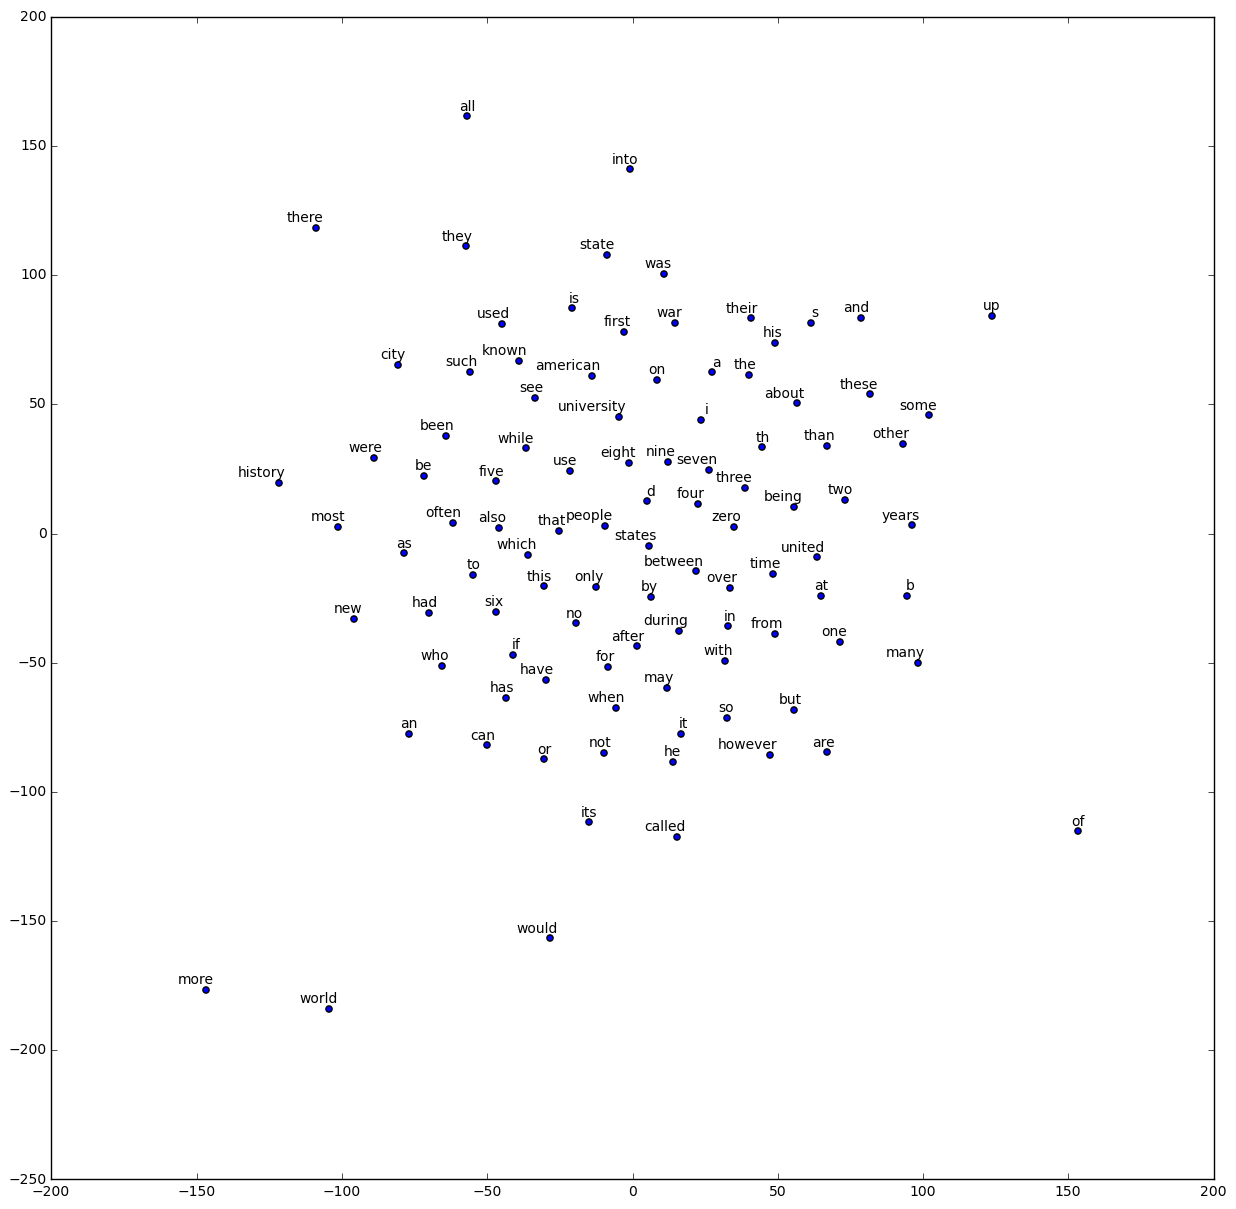

In [64]:
num_points = 100

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

#print(len(final_embeddings))
#print(len(final_embeddings[0]))
#print(final_embeddings[0])
#words = [reverse_dictionary[i] for i in range(1, num_points+1)]
#print(reverse_dictionary[0], final_embeddings[0] )


def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

Conclusion 
------------------------
From  the above skip-gram model, we are able to train a model that given a text can automatically find the words similar to each other with skip-gram models.

In the process they are able to capture the relationshiop between words i.e. Dog, cat are alike (e.g such that they are both animals, four-legged, pets, etc).Also they are able to gather the semantic  relationship i.e Kitten is to cat what puppy is to dog.


---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---